In [12]:
import datetime
import matplotlib
import os
import random
import time
from matplotlib import style

matplotlib.rcParams['axes.grid'] = False
matplotlib.rcParams['image.origin'] = 'lower'
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.visualization import make_lupton_rgb
from astropy.table import Table, vstack
from skypy.pipeline import Pipeline
from slsim.Observations.roman_speclite import configure_roman_filters, filter_names
from pprint import pprint
from glob import glob
import pickle
from tqdm import tqdm
from stips.scene_module import SceneModule
from stips.observation_module import ObservationModule
import speclite
from lenstronomy.Util import data_util, constants
import pandas as pd
import stips

In [13]:
def roman_mag_to_cps(mag, band):
    if band == 'F106':
        mag_zero_point = 26.44
    elif band == 'F129':
        mag_zero_point = 26.40
    elif band == 'F184':
        mag_zero_point = 25.95
    else:
        raise ValueError('Unknown band')

    return data_util.magnitude2cps(mag, mag_zero_point)

In [14]:
num_images = 18  # 18
num_detectors = 1
detector_list = [f'SCA{str(i + 1).zfill(2)}' for i in range(num_detectors)]
bands = ['F106', 'F129', 'F184']
# bands = ['F106']
exposure_time = 1000

obs_prefix = 'nb'
obs_ra = 30.
obs_dec = -30.
output_dir = os.path.join('/data/bwedig/STIPS')

# clear out old files
print('Clearing out old files...')
for f in tqdm(glob(os.path.join(output_dir, '*'))):
    os.remove(f)

# compute detector side in decimal degrees
detector_side_arcsec = 4096 * 0.11
detector_side_deg = detector_side_arcsec / 3600
coord_offset = detector_side_deg / 2

# load Roman WFI filters
configure_roman_filters()
roman_filters = filter_names()
roman_filters.sort()
_ = speclite.filters.load_filters(*roman_filters[:8])

Clearing out old files...


100%|██████████| 3/3 [00:00<00:00, 815.33it/s]

In [15]:
# execute SkyPy galaxy photometry simulation pipeline
pipeline = Pipeline.read('roman_hlwas.yml')
pipeline.execute()

galaxies = []
n_sersic_list = []

for gal in pipeline['blue']:
    n_sersic = np.random.normal(loc=1, scale=0.25, size=1)[0]
    n_sersic_list.append(n_sersic)
    galaxies.append(gal)

for gal in pipeline['red']:
    n_sersic = np.random.normal(loc=4, scale=1., size=1)[0]
    n_sersic_list.append(n_sersic)
    galaxies.append(gal)

output_rows = []
id = 0

In [16]:
for gal, n_sersic in tqdm(zip(galaxies, n_sersic_list), total=len(galaxies)):
    # build information that STIPS needs
    gal_dict = {}
    gal_dict['id'] = id
    gal_dict['ra'] = np.random.uniform(low=obs_ra - coord_offset, high=obs_ra + coord_offset, size=1)[0]
    gal_dict['dec'] = np.random.uniform(low=obs_dec - coord_offset, high=obs_dec + coord_offset, size=1)[0]
    gal_dict['F106'] = roman_mag_to_cps(mag=gal['mag_F106'], band='F106')
    gal_dict['F129'] = roman_mag_to_cps(mag=gal['mag_F129'], band='F129')
    gal_dict['F184'] = roman_mag_to_cps(mag=gal['mag_F184'], band='F184')
    gal_dict['type'] = 'sersic'
    gal_dict['n'] = n_sersic
    gal_dict['re'] = gal['angular_size'] * 206265  # STIPS wants units of pixels (206265 / 0.11)
    gal_dict['phi'] = np.random.uniform(low=0, high=360, size=1)[0]
    gal_dict['ratio'] = np.random.normal(loc=0.8, scale=0.1, size=1)[0]
    gal_dict['notes'] = ''
    output_rows.append(gal_dict)
    id += 1

  0%|          | 0/37413 [00:00<?, ?it/s]

100%|██████████| 37413/37413 [00:01<00:00, 25394.03it/s]


In [27]:
sorted_rows = sorted(output_rows, key=lambda d: d['re'], reverse=True)

# filter out biggest
# rows_to_write = [row for row in sorted_rows if row['re'] < 10]  # 1e2 < row['F106'] and 

# limit
rows_to_write = random.sample(sorted_rows, 50)

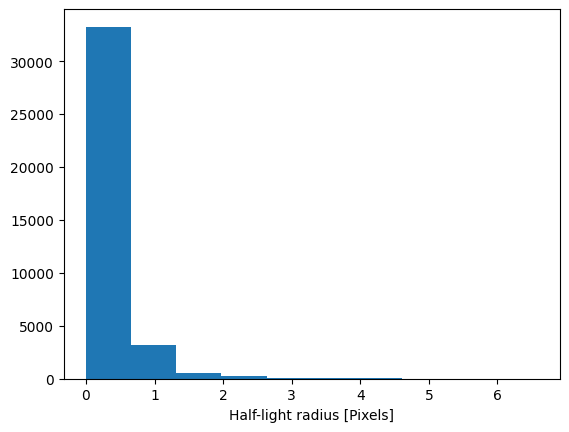

In [30]:
re_list = [gal['re'] for gal in output_rows]

plt.hist(re_list)
plt.xlabel('Half-light radius [Pixels]')
# plt.xlim([0,10])
plt.show()

In [19]:


# from pprint import pprint
# pprint(rows_to_write)

# write to fits file
df = pd.DataFrame(rows_to_write)
table = Table.from_pandas(df)
galaxy_cat_file = os.path.join(output_dir, f'{obs_prefix}_gals_000.fits')
table.write(galaxy_cat_file, format='fits', overwrite=True)

# set type header so STIPS knows how to interpret it
with fits.open(galaxy_cat_file, mode='update') as hdul:
    hdr = hdul[1].header
    hdr['TYPE'] = 'multifilter'

In [20]:
scm = SceneModule(out_prefix=f'{obs_prefix}', ra=obs_ra, dec=obs_dec, out_path=output_dir)

stellar_parameters = {
    'n_stars': 1,  # 1000
    'age_low': 11e12,  # 7.5e12
    'age_high': 2e12,  # 7.5e12
    'z_low': -2.0,
    'z_high': -2.0,
    'imf': 'salpeter',
    'alpha': -2.35,
    'binary_fraction': 0.1,
    'clustered': False,
    'distribution': 'uniform',
    'radius': 275.,  # 100.
    'radius_units': 'arcsec',
    'distance_low': 5.,  # 10.0
    'distance_high': 15.0,  # 10.0
    'offset_ra': 0.0,
    'offset_dec': 0.0
}
stellar_cat_file = scm.CreatePopulation(stellar_parameters)

print("Stellar population saved to file {}".format(stellar_cat_file))
print("Galaxy population saved to file {}".format(galaxy_cat_file))

2024-04-20 09:38:37,941 INFO: Creating catalogue /data/bwedig/STIPS/nb_stars_000.fits
2024-04-20 09:38:37,944 INFO: Creating age and metallicity numbers
2024-04-20 09:38:37,947 INFO: Created age and metallicity numbers
2024-04-20 09:38:37,950 INFO: Creating stars
2024-04-20 09:38:37,954 INFO: Age 1.35e+10
2024-04-20 09:38:37,957 INFO: Metallicity -2.000000
2024-04-20 09:38:37,959 INFO: Creating 1 stars


Log level: INFO


2024-04-20 09:38:39,192 INFO: Creating 1 objects, max radius 275.0, function uniform, scale 2.8
2024-04-20 09:38:39,461 INFO: Chunk 1: 0 stars
2024-04-20 09:38:39,535 INFO: Done creating catalogue


Stellar population saved to file /data/bwedig/STIPS/nb_stars_000.fits
Galaxy population saved to file /data/bwedig/STIPS/nb_gals_000.fits


In [21]:
offset = {
    'offset_id': 1,
    'offset_centre': False,
    'offset_ra': 0,
    'offset_dec': 0,
    'offset_pa': 0.0
}

residuals = {
    'residual_flat': True,
    'residual_dark': True,
    'residual_cosmic': True,
    'residual_poisson': True,
    'residual_readnoise': True
}

observation_parameters = {
    'instrument': 'WFI',
    'filters': bands,
    'detectors': num_detectors,
    'distortion': True,
    'background': 0.15,
    'observations_id': 1,
    'exptime': exposure_time,
    'offsets': [offset]
}

obm = ObservationModule(observation_parameters, out_prefix=f'{obs_prefix}', ra=obs_ra, dec=obs_dec, residual=residuals,
                        out_path=output_dir, fast_galaxies=True)

2024-04-20 09:38:39,571 INFO: Got offsets as [{'offset_id': 1, 'offset_centre': False, 'offset_ra': 0, 'offset_dec': 0, 'offset_pa': 0.0}]


2024-04-20 09:38:39,668 INFO: Adding observation with filter F106 and offset (0,0,0.0)
2024-04-20 09:38:39,671 INFO: Adding observation with filter F129 and offset (0,0,0.0)
2024-04-20 09:38:39,674 INFO: Adding observation with filter F184 and offset (0,0,0.0)
2024-04-20 09:38:39,677 INFO: Added 3 observations
2024-04-20 09:38:40,174 INFO: WFI with 1 detectors. Central offset (2.065830864204697e-13, -8.945310041616143e-14, 0)


In [22]:
# determine number of observations
num_obs = len(observation_parameters['filters'])

for _ in tqdm(range(num_obs)):
    obm.nextObservation()

    output_stellar_catalogues = obm.addCatalogue(stellar_cat_file)
    output_galaxy_catalogues = obm.addCatalogue(galaxy_cat_file, fast_galaxies=True)

    print("Output Catalogues are {} and {}".format(output_stellar_catalogues, output_galaxy_catalogues))

    obm.addError()

    fits_file, mosaic_file, params = obm.finalize(mosaic=False)

    print("Output FITS file is {}".format(fits_file))
    print("Output Mosaic file is {}".format(mosaic_file))
    print("Observation Parameters are {}".format(params))

  0%|          | 0/3 [00:00<?, ?it/s]2024-04-20 09:38:40,187 INFO: Initializing Observation 0 of 3
2024-04-20 09:38:40,188 INFO: Observation Filter is F106
2024-04-20 09:38:40,189 INFO: Observation (RA,DEC) = (30.0,-30.0) with PA=0.0
2024-04-20 09:38:40,190 INFO: Resetting
2024-04-20 09:38:40,190 INFO: Returning background 0.15.
2024-04-20 09:38:40,194 INFO: Creating Detector SCA01 with (RA,DEC,PA) = (30.0,-30.0,0.0)
2024-04-20 09:38:40,195 INFO: Creating Detector SCA01 with offset (0.0,0.0)
2024-04-20 09:38:40,235 INFO: Creating Instrument with Configuration {'aperture': 'imaging', 'disperser': None, 'filter': 'f106', 'instrument': 'wfi', 'mode': 'imaging'}
2024-04-20 09:38:40,369 INFO: SCA01: (RA, DEC, PA) := (30.0, -30.0, 0.0), detected as (30.0, -30.0, 0.0)
2024-04-20 09:38:40,371 INFO: Detector SCA01 created
2024-04-20 09:38:40,372 INFO: Reset Instrument
2024-04-20 09:38:40,373 INFO: Running catalogue /data/bwedig/STIPS/nb_stars_000.fits
2024-04-20 09:38:40,374 INFO: Adding catalo

Creating pandeia instrument roman.wfi.imaging


2024-04-20 09:38:40,454 INFO: Converting chunk 2
2024-04-20 09:38:40,454 INFO: Converting Phoenix Table to Internal format
2024-04-20 09:38:40,455 INFO: 0 datasets
2024-04-20 09:38:40,488 INFO: Finished converting catalogue to internal format
2024-04-20 09:38:40,489 INFO: Adding catalogue to detector SCA01
2024-04-20 09:38:40,489 INFO: Adding catalogue nb_stars_000_01_conv_F106.fits to AstroImage SCA01
2024-04-20 09:38:40,526 INFO: Determining pixel co-ordinates
2024-04-20 09:38:40,527 INFO: Keeping 0 items
2024-04-20 09:38:40,531 INFO: Added catalogue nb_stars_000_01_conv_F106.fits to AstroImage SCA01
2024-04-20 09:38:40,532 INFO: Finished catalogue /data/bwedig/STIPS/nb_stars_000.fits
2024-04-20 09:38:40,533 INFO: Running catalogue /data/bwedig/STIPS/nb_gals_000.fits
2024-04-20 09:38:40,534 INFO: Adding catalogue /data/bwedig/STIPS/nb_gals_000.fits
2024-04-20 09:38:40,556 INFO: Converting multifilter catalogue
2024-04-20 09:38:40,557 INFO: Preparing output table
2024-04-20 09:38:40,5

Output Catalogues are ['/data/bwedig/STIPS/nb_stars_000_01_conv_F106.fits', '/data/bwedig/STIPS/nb_stars_000_01_conv_F106_observed_SCA01.fits'] and ['/data/bwedig/STIPS/nb_gals_000_01_conv_F106.fits', '/data/bwedig/STIPS/nb_gals_000_01_conv_F106_observed_SCA01.fits']


2024-04-20 09:40:40,592 INFO: SCA01: (RA, DEC, PA) := (0.0, 0.0, 0.0), detected as (0.0, 0.0, 0.0)
2024-04-20 09:40:40,593 INFO: Created AstroImage SCA01 and imported data from FITS file err_flat_wfi.fits
2024-04-20 09:40:40,694 INFO: SCA01: (RA, DEC, PA) := (0.0, 0.0, 0.0), detected as (0.0, 0.0, 0.0)
2024-04-20 09:40:41,211 INFO: SCA01: (RA, DEC, PA) := (0.0, 0.0, 0.0), detected as (0.0, 0.0, 0.0)
2024-04-20 09:40:41,213 INFO: Created AstroImage SCA01 and imported data from FITS file err_rdrk_wfi.fits
2024-04-20 09:40:41,223 INFO: Adding error to detector SCA01
2024-04-20 09:40:41,224 INFO: Adding background
2024-04-20 09:40:41,225 INFO: Returning background 0.15.
2024-04-20 09:40:41,226 INFO: Background is 0.15 counts/s/pixel
2024-04-20 09:40:41,227 INFO: Returning background 0.15.
2024-04-20 09:40:41,228 INFO: Added background of 0.15 counts/s/pixel
2024-04-20 09:40:41,238 INFO: Inserting correct exposure time
2024-04-20 09:40:41,248 INFO: Cropping Down to base Detector Size
2024-0

Output FITS file is /data/bwedig/STIPS/nb_1_0.fits
Output Mosaic file is None
Observation Parameters are ['Instrument: WFI', 'Filters: F106', 'Pixel Scale: (0.110,0.110) arcsec/pix', 'Pivot Wavelength: 1.060 um', 'Background Type: Set to 0.15', 'Exposure Time: 1000.0s', 'Input Unit: counts/s', 'Added Flatfield Residual: True', 'Added Dark Current Residual: True', 'Added Cosmic Ray Residual: True', 'Added Readnoise: True', 'Added Poisson Noise: True', 'Detector X size: 4088', 'Detector Y size: 4088', 'Random Seed: 0']


2024-04-20 09:40:48,884 INFO: Converting phoenix catalogue
2024-04-20 09:40:48,887 INFO: Preparing output table
2024-04-20 09:40:48,937 INFO: Converting chunk 2
2024-04-20 09:40:48,941 INFO: Converting Phoenix Table to Internal format
2024-04-20 09:40:48,944 INFO: 0 datasets
2024-04-20 09:40:49,011 INFO: Finished converting catalogue to internal format
2024-04-20 09:40:49,015 INFO: Adding catalogue to detector SCA01
2024-04-20 09:40:49,019 INFO: Adding catalogue nb_stars_000_01_conv_F129.fits to AstroImage SCA01
2024-04-20 09:40:49,059 INFO: Determining pixel co-ordinates
2024-04-20 09:40:49,062 INFO: Keeping 0 items
2024-04-20 09:40:49,068 INFO: Added catalogue nb_stars_000_01_conv_F129.fits to AstroImage SCA01
2024-04-20 09:40:49,071 INFO: Finished catalogue /data/bwedig/STIPS/nb_stars_000.fits
2024-04-20 09:40:49,074 INFO: Running catalogue /data/bwedig/STIPS/nb_gals_000.fits
2024-04-20 09:40:49,077 INFO: Adding catalogue /data/bwedig/STIPS/nb_gals_000.fits
2024-04-20 09:40:49,102 I

Output Catalogues are ['/data/bwedig/STIPS/nb_stars_000_01_conv_F129.fits', '/data/bwedig/STIPS/nb_stars_000_01_conv_F129_observed_SCA01.fits'] and ['/data/bwedig/STIPS/nb_gals_000_01_conv_F129.fits', '/data/bwedig/STIPS/nb_gals_000_01_conv_F129_observed_SCA01.fits']


2024-04-20 09:42:47,464 INFO: SCA01: (RA, DEC, PA) := (0.0, 0.0, 0.0), detected as (0.0, 0.0, 0.0)
2024-04-20 09:42:47,472 INFO: Created AstroImage SCA01 and imported data from FITS file err_flat_wfi.fits
2024-04-20 09:42:47,583 INFO: SCA01: (RA, DEC, PA) := (0.0, 0.0, 0.0), detected as (0.0, 0.0, 0.0)
2024-04-20 09:42:48,108 INFO: SCA01: (RA, DEC, PA) := (0.0, 0.0, 0.0), detected as (0.0, 0.0, 0.0)
2024-04-20 09:42:48,114 INFO: Created AstroImage SCA01 and imported data from FITS file err_rdrk_wfi.fits
2024-04-20 09:42:48,127 INFO: Adding error to detector SCA01
2024-04-20 09:42:48,132 INFO: Adding background
2024-04-20 09:42:48,136 INFO: Returning background 0.15.
2024-04-20 09:42:48,139 INFO: Background is 0.15 counts/s/pixel
2024-04-20 09:42:48,142 INFO: Returning background 0.15.
2024-04-20 09:42:48,145 INFO: Added background of 0.15 counts/s/pixel
2024-04-20 09:42:48,156 INFO: Inserting correct exposure time
2024-04-20 09:42:48,168 INFO: Cropping Down to base Detector Size
2024-0

Output FITS file is /data/bwedig/STIPS/nb_1_1.fits
Output Mosaic file is None
Observation Parameters are ['Instrument: WFI', 'Filters: F129', 'Pixel Scale: (0.110,0.110) arcsec/pix', 'Pivot Wavelength: 1.293 um', 'Background Type: Set to 0.15', 'Exposure Time: 1000.0s', 'Input Unit: counts/s', 'Added Flatfield Residual: True', 'Added Dark Current Residual: True', 'Added Cosmic Ray Residual: True', 'Added Readnoise: True', 'Added Poisson Noise: True', 'Detector X size: 4088', 'Detector Y size: 4088', 'Random Seed: 0']


2024-04-20 09:42:56,043 INFO: Finished converting catalogue to internal format
2024-04-20 09:42:56,046 INFO: Adding catalogue to detector SCA01
2024-04-20 09:42:56,049 INFO: Adding catalogue nb_stars_000_01_conv_F184.fits to AstroImage SCA01
2024-04-20 09:42:56,098 INFO: Determining pixel co-ordinates
2024-04-20 09:42:56,102 INFO: Keeping 0 items
2024-04-20 09:42:56,107 INFO: Added catalogue nb_stars_000_01_conv_F184.fits to AstroImage SCA01
2024-04-20 09:42:56,112 INFO: Finished catalogue /data/bwedig/STIPS/nb_stars_000.fits
2024-04-20 09:42:56,115 INFO: Running catalogue /data/bwedig/STIPS/nb_gals_000.fits
2024-04-20 09:42:56,117 INFO: Adding catalogue /data/bwedig/STIPS/nb_gals_000.fits
2024-04-20 09:42:56,138 INFO: Converting multifilter catalogue
2024-04-20 09:42:56,141 INFO: Preparing output table
2024-04-20 09:42:56,179 INFO: Converting chunk 2
2024-04-20 09:42:56,215 INFO: Finished converting catalogue to internal format
2024-04-20 09:42:56,219 INFO: Adding catalogue to detecto

Output Catalogues are ['/data/bwedig/STIPS/nb_stars_000_01_conv_F184.fits', '/data/bwedig/STIPS/nb_stars_000_01_conv_F184_observed_SCA01.fits'] and ['/data/bwedig/STIPS/nb_gals_000_01_conv_F184.fits', '/data/bwedig/STIPS/nb_gals_000_01_conv_F184_observed_SCA01.fits']


2024-04-20 09:44:55,333 INFO: SCA01: (RA, DEC, PA) := (0.0, 0.0, 0.0), detected as (0.0, 0.0, 0.0)
2024-04-20 09:44:55,337 INFO: Created AstroImage SCA01 and imported data from FITS file err_flat_wfi.fits
2024-04-20 09:44:55,448 INFO: SCA01: (RA, DEC, PA) := (0.0, 0.0, 0.0), detected as (0.0, 0.0, 0.0)
2024-04-20 09:44:55,975 INFO: SCA01: (RA, DEC, PA) := (0.0, 0.0, 0.0), detected as (0.0, 0.0, 0.0)
2024-04-20 09:44:55,980 INFO: Created AstroImage SCA01 and imported data from FITS file err_rdrk_wfi.fits
2024-04-20 09:44:55,996 INFO: Adding error to detector SCA01
2024-04-20 09:44:56,000 INFO: Adding background
2024-04-20 09:44:56,004 INFO: Returning background 0.15.
2024-04-20 09:44:56,008 INFO: Background is 0.15 counts/s/pixel
2024-04-20 09:44:56,013 INFO: Returning background 0.15.
2024-04-20 09:44:56,017 INFO: Added background of 0.15 counts/s/pixel
2024-04-20 09:44:56,030 INFO: Inserting correct exposure time
2024-04-20 09:44:56,047 INFO: Cropping Down to base Detector Size
2024-0

Output FITS file is /data/bwedig/STIPS/nb_1_2.fits
Output Mosaic file is None
Observation Parameters are ['Instrument: WFI', 'Filters: F184', 'Pixel Scale: (0.110,0.110) arcsec/pix', 'Pivot Wavelength: 1.842 um', 'Background Type: Set to 0.15', 'Exposure Time: 1000.0s', 'Input Unit: counts/s', 'Added Flatfield Residual: True', 'Added Dark Current Residual: True', 'Added Cosmic Ray Residual: True', 'Added Readnoise: True', 'Added Poisson Noise: True', 'Detector X size: 4088', 'Detector Y size: 4088', 'Random Seed: 0']


In [23]:
# import all FITS files
fits_files = glob(os.path.join(output_dir, f'{obs_prefix}_1_*.fits'))
fits_files.sort()

for f in fits_files:
    pprint(fits.info(f))

for f, band in zip(fits_files, bands):
    for detector in detector_list:
        image = fits.getdata(f, extname=detector)
        save_path = os.path.join(output_dir, f'{obs_prefix}_{band}.npy')
        np.save(save_path, image)
        print(f'Saved to {save_path}')

Filename: /data/bwedig/STIPS/nb_1_0.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  SCA01         1 ImageHDU        53   (4088, 4088)   float32   
None
Filename: /data/bwedig/STIPS/nb_1_1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  SCA01         1 ImageHDU        53   (4088, 4088)   float32   
None
Filename: /data/bwedig/STIPS/nb_1_2.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  SCA01         1 ImageHDU        53   (4088, 4088)   float32   
None
Saved to /data/bwedig/STIPS/nb_F106.npy
Saved to /data/bwedig/STIPS/nb_F129.npy
Saved to /data/bwedig/STIPS/nb_F184.npy


In [24]:
images_f106 = [np.load(f) for f in sorted(glob(os.path.join(output_dir, f'{obs_prefix}_F106*.npy')))]
images_f129 = [np.load(f) for f in sorted(glob(os.path.join(output_dir, f'{obs_prefix}_F129*.npy')))]
images_f184 = [np.load(f) for f in sorted(glob(os.path.join(output_dir, f'{obs_prefix}_F184*.npy')))]

In [25]:
rgb_images = []
for i in tqdm(range(len(images_f106))):
    f106 = images_f106[i]
    f129 = images_f129[i]
    f184 = images_f184[i]
    min = np.min([f106, f129, f184])
    rgb = make_lupton_rgb(f106, f129, f184, minimum=min, stretch=4, Q=10)
    rgb_images.append(rgb)

100%|██████████| 1/1 [00:03<00:00,  3.09s/it]


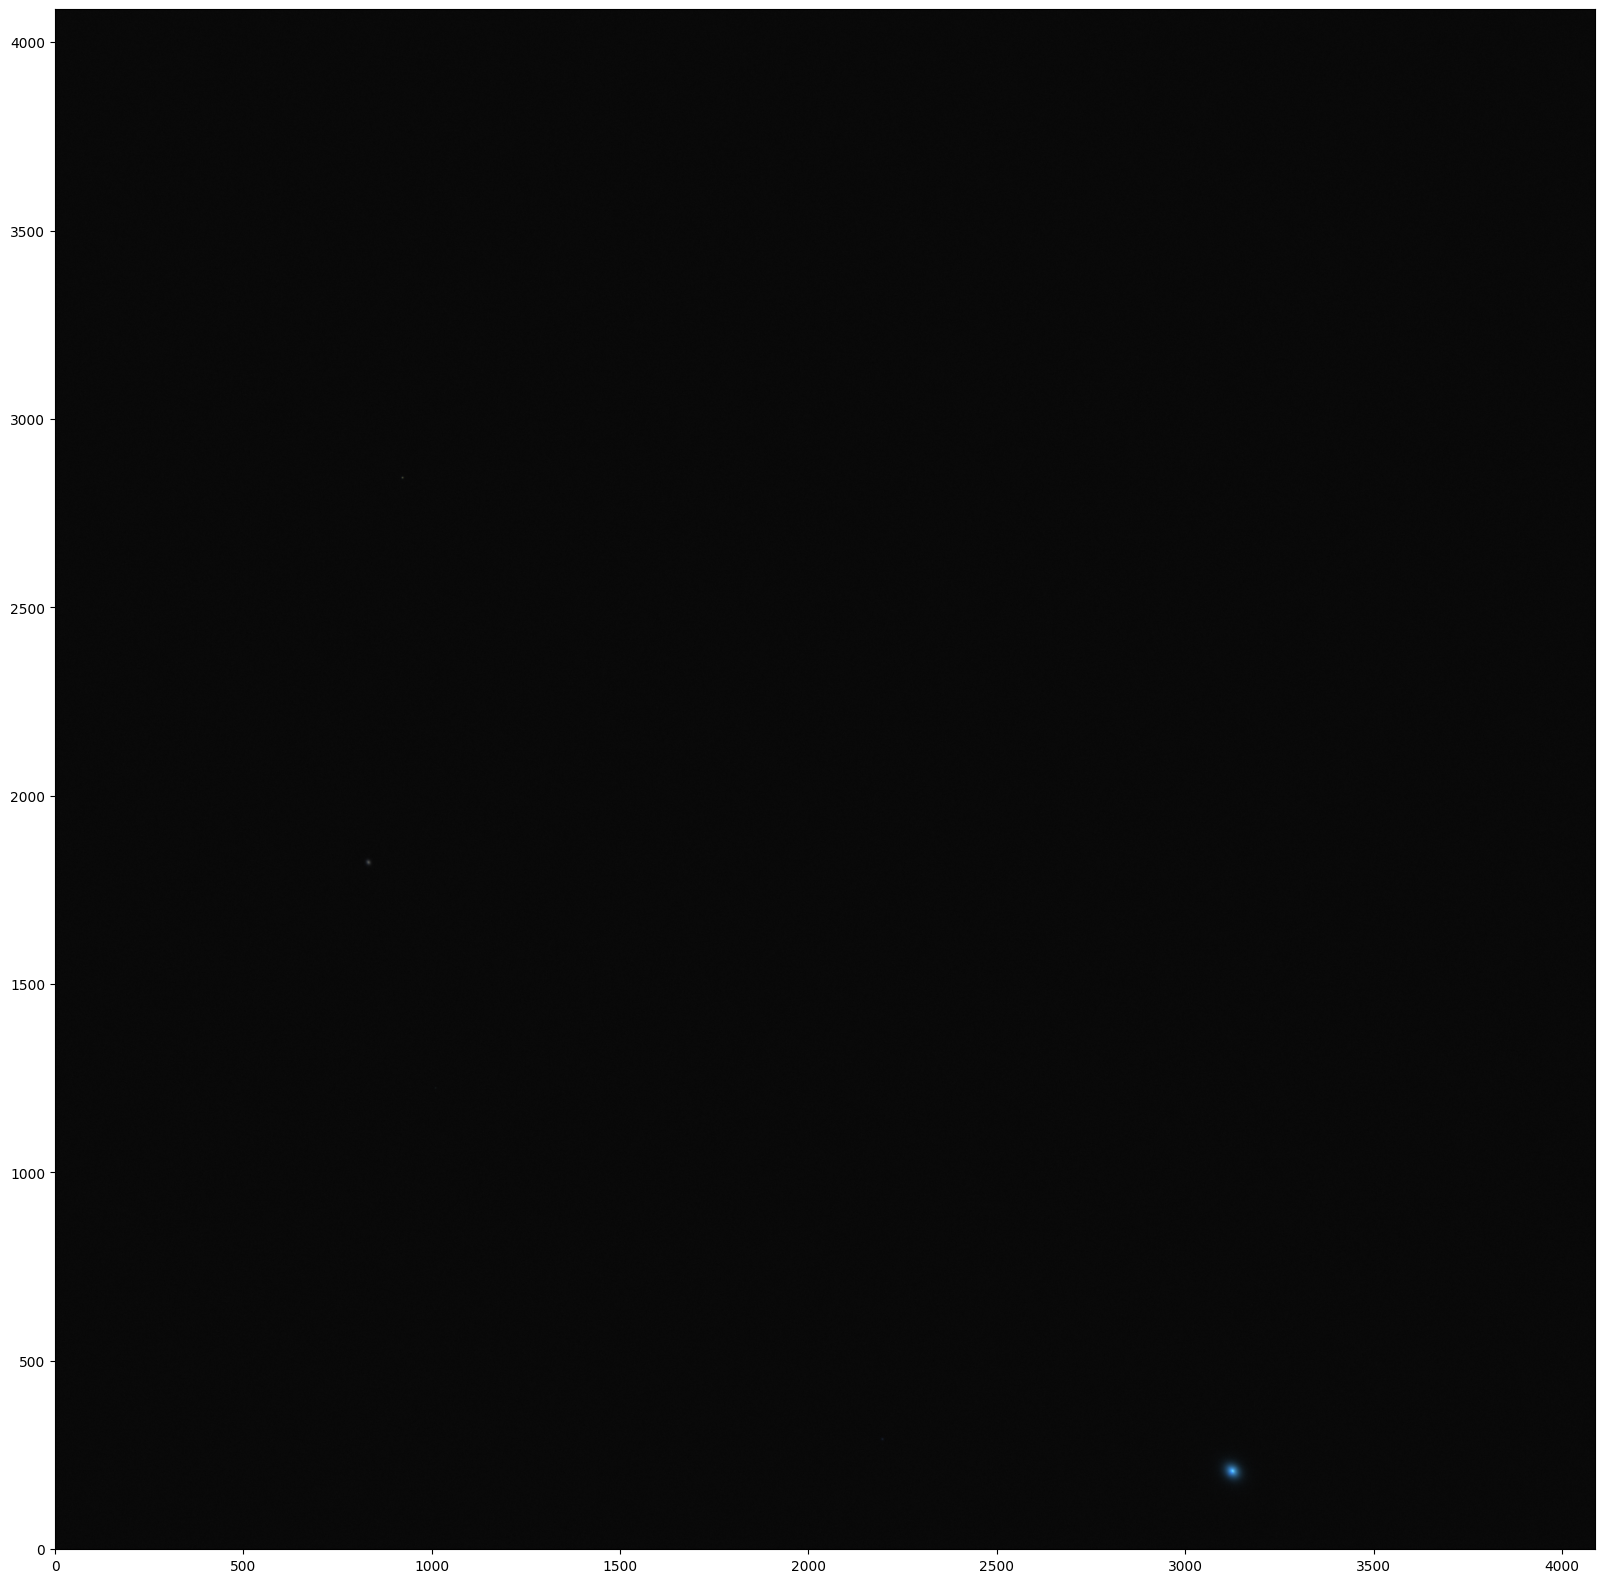

In [26]:
plt.figure(figsize=(20, 20))
plt.imshow(rgb_images[0], origin='lower')  # [500:1000,1500:2000]
plt.show()